## Content:
- [Part 1](#part1)- Importing the libraries, packages
- [Part 2](#part2)- Feature Engineering
- [Part 3](#part3) - Label Encoded Data
- [Part 4](#part4) -  Hot encoded Data
- [Part 5](#part5) -  Scaling Data
- [Part 6](#part6) -  Lasso regression
- [Part 7](#part7) -  ANN 1 hidden layer label encoded data
- [Part 8](#part8) -  ANN 2 hidden layers label encoded data
- [Part 9](#part9) -  ANN 3 hidden layers 
- [Part 10](#part10) -  ANN 4 hidden layers
- [Part 11](#part11) -  Using Hot encoded Data

[Back to top](#Content:)


<a id='part1'></a>

### Part 1 -   Importing the libraries, packages

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder




In [2]:
random.seed(0)

In [3]:
## loading the file
health_care = pd.read_csv('../healthcare/train_data.csv', na_values=['NA', 'NaN', '?'])

In [4]:
# Dropping na values for 
health_care = health_care.dropna()

[Back to top](#Content:)


<a id='part2'></a>


## Feature engineering

We will add 2 features : 
- Visit number
- New Patient

In [5]:
n = health_care.shape[0]
visits = []
patientid = np.array(health_care['patientid'])
for i in range(n) :
    count = (patientid[:i+1] == patientid[i]).sum()
    visits.append(count)
    
health_care['Visit Number'] = visits
health_care['New Patient'] = (health_care['Visit Number']==1).astype('int32')

In [6]:
health_care.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Visit Number,New Patient
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,2,0
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,3,0
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,4,0
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,5,0


[Back to top](#Content:)


<a id='part3'></a>

## Label Encoded Data

In [8]:
from tensorflow.keras.utils import to_categorical
## Columns to be label encoded

string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission', 'Severity of Illness', 'Age' ]
encoder = LabelEncoder()


## label_encoded data
X_le = health_care.drop(['Stay', 'case_id'], axis=1)
y_le = health_care['Stay']

y_le = encoder.fit_transform(y_le)
y_cat = to_categorical(encoder.fit_transform(health_care['Stay']))
for column in string_columns :
    X_le[column] = encoder.fit(X_le[column]).transform(X_le[column])
    

In [8]:
y_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

[Back to top](#Content:)


<a id='part4'></a>
## Hot encoded Data

In [5]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) ## inplace to make changed on the original df

In [6]:
## Pre processing these columns

le_string_columns = [  'Severity of Illness', 'Age' ]
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()
#ohEncoder = OneHotEncoder()

## label_encoded data
Xe = health_care.drop(['Stay', 'case_id', 'City_Code_Hospital', 'Bed Grade'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = health_care['Stay']
ye = encoder.fit_transform(ye)
ye = 10*ye + 5
ye

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

[Back to top](#Content:)


<a id='part5'></a>
## Scaling Label Encoded Data

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = X_le.values
y = y_le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

[Back to top](#Content:)


<a id='part6'></a>
## Lasso for preliminar feature selection

In [20]:
# Function to plot Lasso coef
def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': np.abs(coef)  }, index = names )
    r = r.sort_values(by=['positive'], ascending=True)
    display(r)
    print("Intercept: {}".format(intercept))
    plt.xlabel('covariate coefficient')
    r['coef'].plot(kind='barh')

In [21]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn import metrics

# Create linear regression
regressor = Lasso(alpha=0.1)

# Fit/train LASSO
regressor.fit(X_train,y_train)
# Predict
X_pred = regressor.predict(X_test)

a= regressor.coef_
b = regressor.intercept_
c = np.sqrt(metrics.mean_squared_error(X_pred,y_test))

print('RMSE : %.2f' % c)
print('score : %.2f' % regressor.score(X_train,y_train))



RMSE : 1.72
score : 0.35


,coef,positive
Hospital_code,0.000000,0.000000
Admission_Deposit,0.000000,0.000000
Severity of Illness,-0.000000,0.000000
City_Code_Patient,-0.000000,0.000000
patientid,-0.000000,0.000000
Visit Number,-0.000000,0.000000
Ward_Facility_Code,0.000000,0.000000
Bed Grade,-0.000000,0.000000
Department,0.000000,0.000000
Hospital_region_code,0.000000,0.000000


Intercept: 2.698585899789245


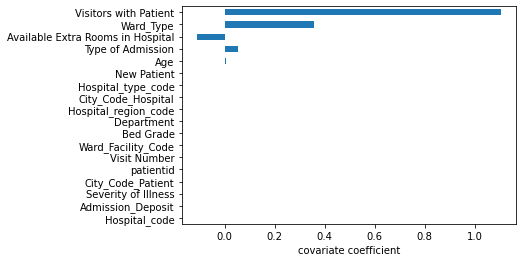

In [22]:
names = list(X_le.columns.values)
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

[Back to top](#Content:)


<a id='part7'></a>
# ANN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


## Data for network 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

In [25]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (235344, 18)
y_train shape (235344, 11)
X_test shape (78449, 18)
y_test shape (78449, 11)


### First Model

In [26]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')

#model.add(Dropout(0.1,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
#model.add(Dense(20, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 11)                715       
                                                                 
Total params: 1,931
Trainable params: 1,931
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [==============================] - 4s 637us/step - loss: 1.6425 - accuracy: 0.3800 - val_loss: 1.5999 - val_accuracy: 0.3930
Epoch 2/100
5884/5884 [==============================] - 4s 612us/step - loss: 1.5862 - accuracy: 0.3967 - val_loss: 1.5783 - val_accuracy: 0.3979
Epoch 3/100
5884/5884 [==============================] - 4s 612us/step - loss: 1.5680 - accuracy: 0.4017 - val_loss: 1.5685 - val_accuracy: 0.4001
Epoch 4/1

Accuracy score: 0.4146260627923874


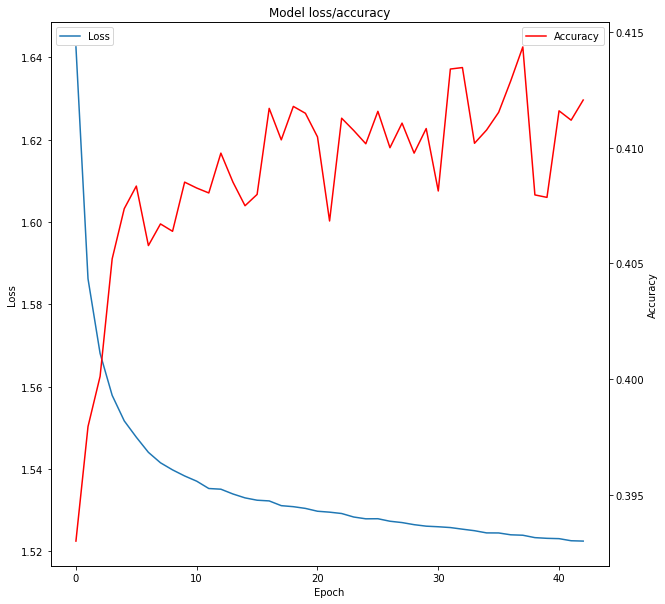

In [27]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1) 
#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


### Second Model

In [28]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')

#model.add(Dropout(0.1,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
#model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1216      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 11)                715       
                                                                 
Total params: 1,931
Trainable params: 1,931
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [==============================] - 4s 665us/step - loss: 1.6653 - accuracy: 0.3704 - val_loss: 1.5991 - val_accuracy: 0.3935
Epoch 2/100
5884/5884 [==============================] - 4s 636us/step - loss: 1.6046 - accuracy: 0.3906 - val_loss: 1.5836 - val_accuracy: 0.3984
Epoch 3/100
5884/5884 

Accuracy score: 0.4116942217236676


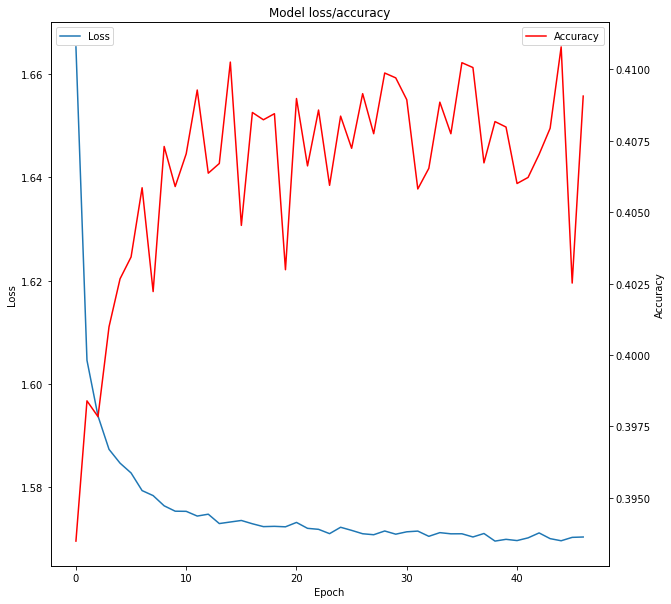

In [29]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


### Model 3

In [30]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

model.add(Dropout(0.1,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
#model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 18)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                1216      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 11)                715       
                                                                 
Total params: 1,931
Trainable params: 1,931
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [==============================] - 4s 712us/step - loss: 1.7009 - accuracy: 0.3572 - val_loss: 1.6089 - val_accuracy: 0.3922
Epoch 2/100
5884/5884 [==============

In [32]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

#model.add(Dropout(0.1,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
model.add(Dense(64, activation='relu'))
#model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1216      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 11)                715       
                                                                 
Total params: 6,091
Trainable params: 6,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [==============================] - 4s 703us/step - loss: 1.6286 - accuracy: 0.3815 - val_loss: 1.5651 - val_accuracy: 0.3992
Epoch 2/100
5884/5884 [==============

Accuracy score: 0.4195974454741297


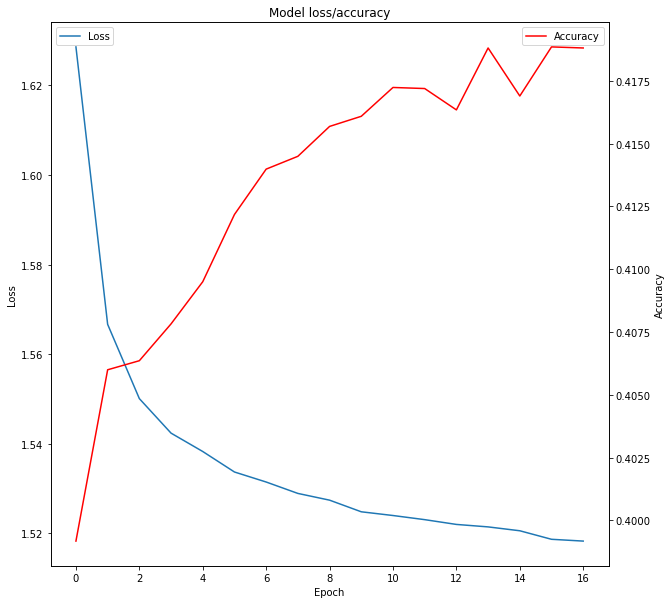

In [33]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


[Back to top](#Content:)


<a id='part8'></a>
### Model with 2 hidden layers

In [34]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

model.add(Dropout(0.1,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
model.add(Dense(64, activation='relu'))
#model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 18)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                1216      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 11)                715       
                                                                 
Total params: 6,091
Trainable params: 6,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [=============================

Accuracy score: 0.41698428278244465


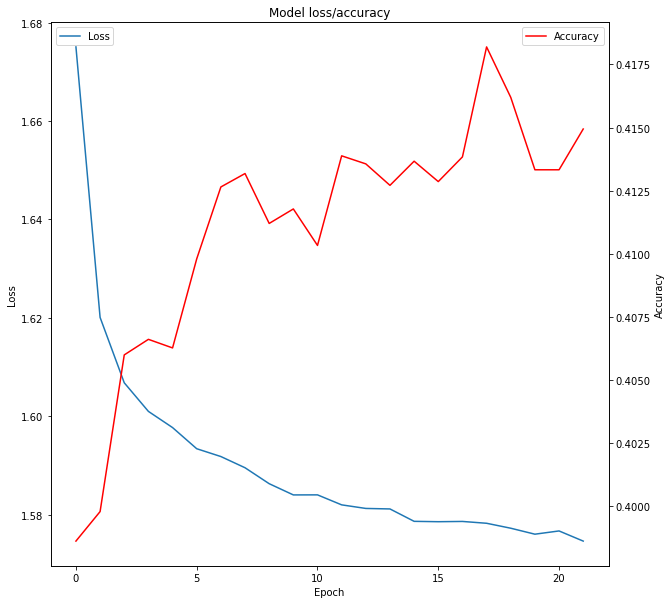

In [35]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


## Other model

In [36]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

model.add(Dropout(0.25,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 18)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                1216      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 20)                1300      
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 11)               

Accuracy score: 0.401522007928718


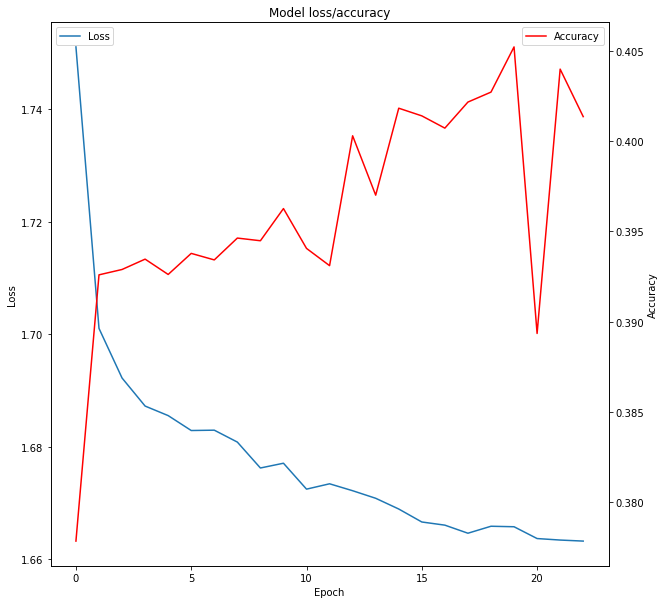

In [37]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


[Back to top](#Content:)


<a id='part9'></a>
### Another model 3 hidden layers

In [39]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

#model.add(Dropout(0.25,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(20, activation='sigmoid'))
#model.add(Dropout(0.25))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                1216      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 20)                1300      
                                                                 
 dense_19 (Dense)            (None, 11)                231       
                                                                 
Total params: 6,907
Trainable params: 6,907
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [==============================] - 5s 725us/step - loss: 1.6074 - accuracy: 0.3858 - val_loss: 1.5674 - val_accuracy: 0.4005
Epoch 2/100
5884/5884 [==============

Accuracy score: 0.4177363637522467


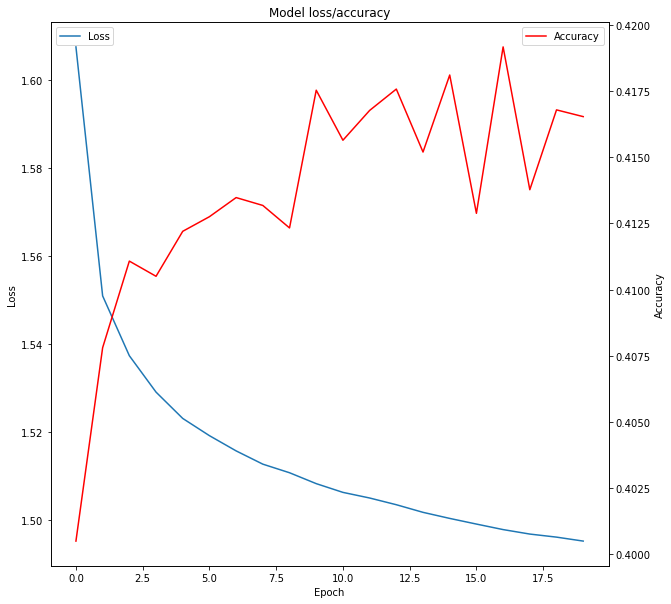

In [40]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


Text(91.68, 0.5, 'pred label')

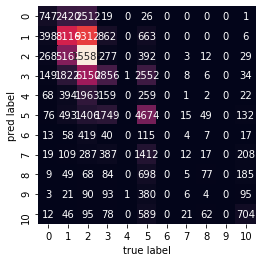

In [43]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           )
plt.xlabel('true label')
plt.ylabel('pred label')

[Back to top](#Content:)


<a id='part10'></a>
# Model with 4 hidden layers

In [44]:
model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

#model.add(Dropout(0.25,input_shape=(X.shape[1],)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)
pred = model.predict(X_test)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                1216      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 40)                2600      
                                                                 
 dense_23 (Dense)            (None, 30)                1230      
                                                                 
 dense_24 (Dense)            (None, 11)                341       
                                                                 
Total params: 9,547
Trainable params: 9,547
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5884/5884 [=============================

Accuracy score: 0.41532715522186386


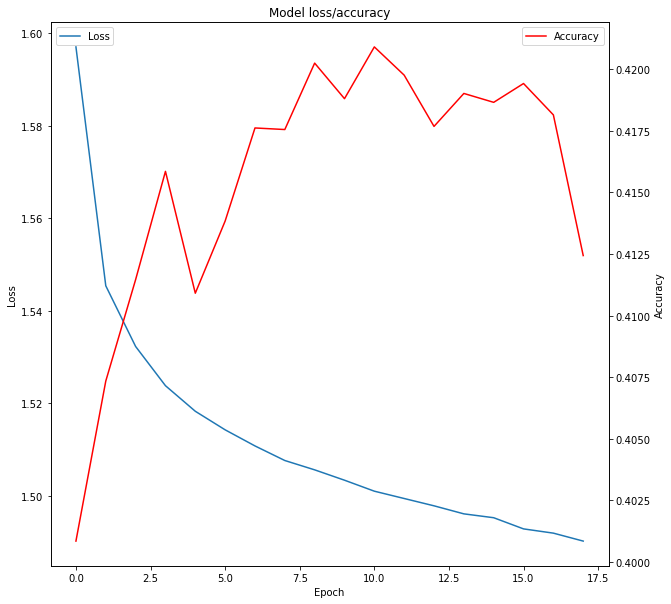

In [45]:
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


Text(91.68, 0.5, 'pred label')

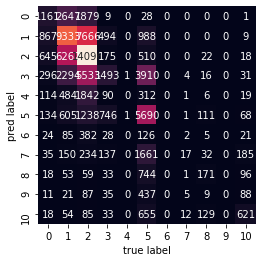

In [46]:

mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           )
plt.xlabel('true label')
plt.ylabel('pred label')

 [Back to top](#Content:)


<a id='part11'></a>
 # Using Hot Encoded Data

## Scaling Hot encoded Data

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = Xe.values
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

NameError: name 'y_cat' is not defined

In [17]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (235344, 40)
y_train shape (235344, 11)
X_test shape (78449, 40)
y_test shape (78449, 11)


# First model 1 hidden layer

In [18]:

model = Sequential()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')

#model.add(Dropout(0.1,input_shape=(X.shape[1],)))
model.add(Dense(24, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
model.add(Dense(20, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)



2021-12-07 20:40:57.803449: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-07 20:40:57.805449: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                984       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                231       
Total params: 1,715
Trainable params: 1,715
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/100
188275/188275 [==============================] - 8s 45us/sample - loss: 1.6285 - accuracy: 0.3739 - val_loss: 1.5742 - val_accuracy: 0.3930
Epoch 2/100
188275/188275 [==============================] - 8s 41us/sample - loss: 1.5639 - accuracy: 0.3957 - val_loss: 1.5608 - val_accuracy: 0.3970
Epoch 3/100
188275/188275 [==

In [20]:
def score(y_test, y_pred):
    cat_number = len(np.unique(y_test))
    score = 1-np.sum(np.abs(y_test-y_pred))/((cat_number-1)*len(y_test))
    return score
    

Accuracy score: 0.4076788741730296


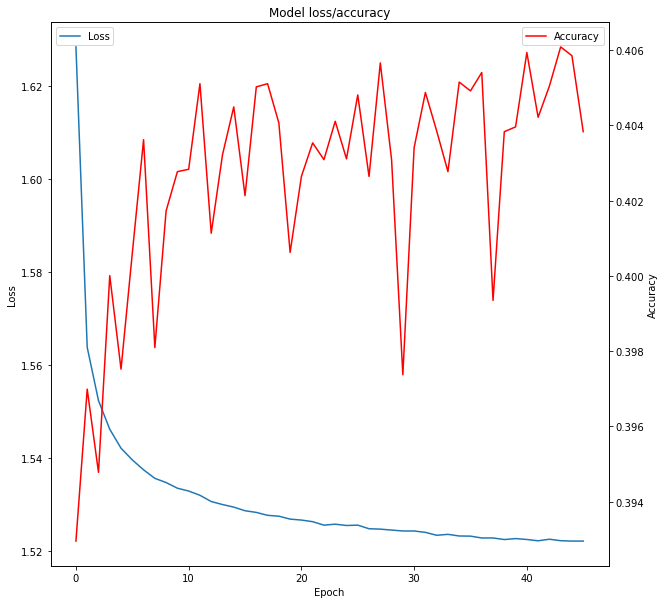

In [23]:
from sklearn import metrics
y_compare = np.argmax(y_test,axis=1) 

#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


Text(91.68, 0.5, 'pred label')

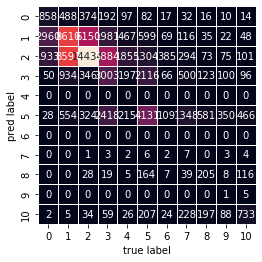

In [51]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,linewidths=.7
           )
plt.xlabel('true label')
plt.ylabel('pred label')

In [30]:
pred.shape

(78449,)

In [31]:
y_compare.shape

(78449,)

In [35]:
len(np.unique(y_compare))

11

In [54]:
(np.unique(pred))

array([ 0,  1,  2,  3,  5,  7,  8,  9, 10])

In [39]:
cat_number = len(np.unique(y_compare))
score = 1-np.sum(np.abs(y_compare -pred))/((cat_number-1)*len(y_compare))

In [40]:
print(score)

0.8920738314063914


## Model with less parameters


In [19]:
print(Xe.columns)

Index(['Hospital_code', 'Available Extra Rooms in Hospital', 'patientid',
       'City_Code_Patient', 'Severity of Illness', 'Visitors with Patient',
       'Age', 'Admission_Deposit', 'Hospital_type_code-a',
       'Hospital_type_code-b', 'Hospital_type_code-c', 'Hospital_type_code-d',
       'Hospital_type_code-e', 'Hospital_type_code-f', 'Hospital_type_code-g',
       'Hospital_region_code-X', 'Hospital_region_code-Y',
       'Hospital_region_code-Z', 'Department-TB & Chest disease',
       'Department-anesthesia', 'Department-gynecology',
       'Department-radiotherapy', 'Department-surgery', 'Ward_Type-P',
       'Ward_Type-Q', 'Ward_Type-R', 'Ward_Type-S', 'Ward_Type-T',
       'Ward_Type-U', 'Ward_Facility_Code-A', 'Ward_Facility_Code-B',
       'Ward_Facility_Code-C', 'Ward_Facility_Code-D', 'Ward_Facility_Code-E',
       'Ward_Facility_Code-F', 'Type of Admission-Emergency',
       'Type of Admission-Trauma', 'Type of Admission-Urgent'],
      dtype='object')


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = Xe[['Hospital_code','Severity of Illness', 'Visitors with Patient','Ward_Type-P',
       'Ward_Type-Q', 'Ward_Type-R', 'Ward_Type-S', 'Ward_Type-T',
       'Ward_Type-U','Ward_Facility_Code-A', 'Ward_Facility_Code-B',
       'Ward_Facility_Code-C', 'Ward_Facility_Code-D', 'Ward_Facility_Code-E',
       'Ward_Facility_Code-F', 'Type of Admission-Emergency',
       'Type of Admission-Trauma', 'Type of Admission-Urgent' ]].values
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

In [21]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (235344, 18)
y_train shape (235344, 11)
X_test shape (78449, 18)
y_test shape (78449, 11)


In [22]:

model = Sequential()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
model.add(Dense(24, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
model.add(Dense(24, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                456       
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 11)                275       
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/100
188275/188275 [==============================] - 8s 41us/sample - loss: 1.7423 - accuracy: 0.3304 - val_loss: 1.7177 - val_accuracy: 0.3357
Epoch 2/100
188275/188275 [==============================] - 7s 37us/sample - loss: 1.7153 - accuracy: 0.3364 - val_loss: 1.7120 - val_accuracy: 0.3380
Epoch 3/100
188275/188275 [

Accuracy score: 0.3432293592015195


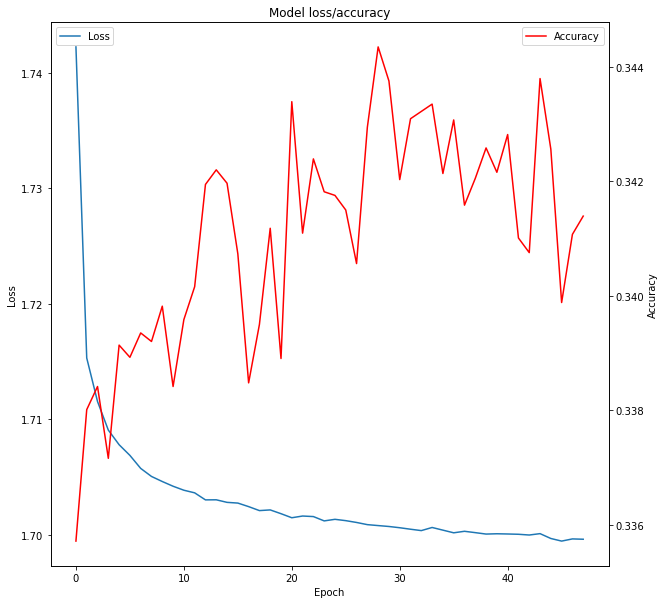

In [26]:
from sklearn import metrics
y_compare = np.argmax(y_test,axis=1) 
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


Text(91.68, 0.5, 'pred label')

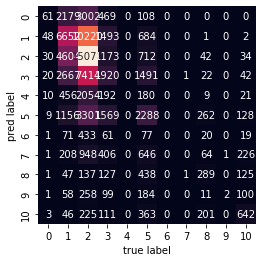

In [28]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           )
plt.xlabel('true label')
plt.ylabel('pred label')

In [29]:
X = Xe[['Severity of Illness', 'Visitors with Patient',
       'Age','Ward_Type-P',
       'Ward_Type-Q', 'Ward_Type-R', 'Ward_Type-S', 'Ward_Type-T',
       'Ward_Type-U', ]].values
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

In [30]:

model = Sequential()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
model.add(Dense(24, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
model.add(Dense(24, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 24)                240       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 11)                275       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/100
188275/188275 [==============================] - 8s 40us/sample - loss: 1.7659 - accuracy: 0.3213 - val_loss: 1.7386 - val_accuracy: 0.3265
Epoch 2/100
188275/188275 [==============================] - 7s 37us/sample - loss: 1.7421 - accuracy: 0.3262 - val_loss: 1.7370 - val_accuracy: 0.32721.7431 -  - ETA: 0s - loss: 

Accuracy score: 0.3307371668217568


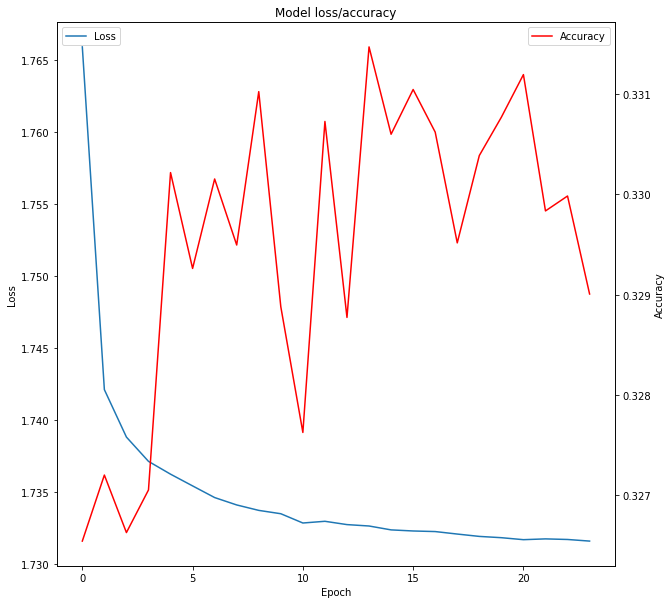

In [31]:
from sklearn import metrics
y_compare = np.argmax(y_test,axis=1) 
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


Text(91.68, 0.5, 'pred label')

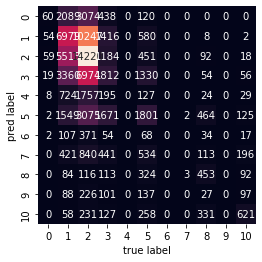

In [32]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           )
plt.xlabel('true label')
plt.ylabel('pred label')

## All Data again

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = Xe.values
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

In [34]:

model = Sequential()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')
model.add(Dense(24, input_dim=X.shape[1], activation='relu'))
#you might experiment with a second hidden layer
#model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_cat.shape[1],activation='softmax'))
#compile the model setting the loss (error) measure and the optimizer
#opt = keras.optimizers.SGD(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
r = model.fit(X_train,y_train,verbose=1, callbacks=[monitor],validation_split=0.2, epochs=100)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 24)                936       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                800       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 11)                363       
Total params: 2,099
Trainable params: 2,099
Non-trainable params: 0
_________________________________________________________________
Train on 188275 samples, validate on 47069 samples
Epoch 1/100
188275/188275 [==============================] - 9s 48us/sample - loss: 1.6593 - accuracy: 0.3641 - val_loss: 1.5740 - val_accuracy: 0.3977
Epoch 2/100
188275/188275 [====================

In [73]:
np.unique(pred)

array([ 0,  1,  2,  3,  5,  8, 10])

Accuracy score: 0.40250353732998506


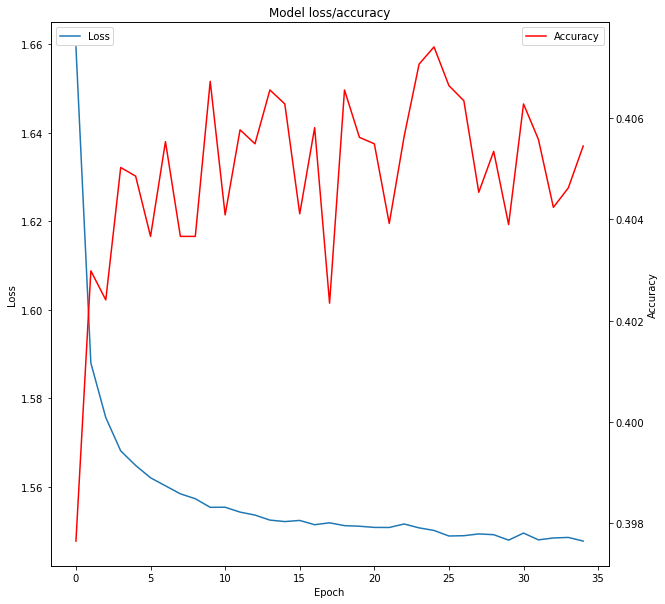

In [35]:
from sklearn import metrics
y_compare = np.argmax(y_test,axis=1) 
#make predictions (will give a probability distribution)
pred = model.predict(X_test)

#now pick the most likely outcome
pred = np.argmax(pred,axis=1)

#and calculate accuracy
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))


plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss')
plt.legend(['Loss'], loc='upper left')
plt.xlabel('Epoch')

plt2=plt.twinx()
color = 'red'
plt2.plot(r.history['val_accuracy'],color=color)
plt.ylabel('Accuracy')
plt2.legend(['Accuracy'], loc='upper right')
plt.show()


Text(91.68, 0.5, 'pred label')

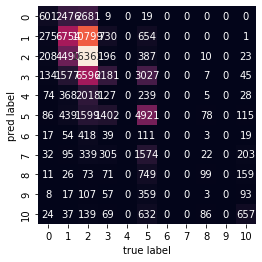

In [36]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidths=.5
           )
plt.xlabel('true label')
plt.ylabel('pred label')

In [42]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
health_care['Stay_cat'] = encoder.fit_transform(health_care['Stay'])

In [43]:
print(np.unique(health_care['Stay_cat']))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [50]:
n = len(health_care['Stay_cat'])
l = []
for i in range(len(np.unique(health_care['Stay_cat']))):
    k = len(health_care[health_care['Stay_cat']==i])
    #print(f'N {10*i} and {10*(i+1)} is : {k}')
    print(f'{i}: {k}  : {100*k/n:.2f}%')
   
    
    
    
    

0: 23250  : 7.41%
1: 77095  : 24.57%
2: 86316  : 27.51%
3: 54312  : 17.31%
4: 11541  : 3.68%
5: 34463  : 10.98%
6: 2698  : 0.86%
7: 10096  : 3.22%
8: 4761  : 1.52%
9: 2713  : 0.86%
10: 6548  : 2.09%


In [66]:
t = 0
for i in range(5):
    t+=len(health_care[health_care['Stay_cat']==10-i])
    
print(f'{100*t/n:.2f}%')

8.55%


Text(91.68, 0.5, 'pred label')

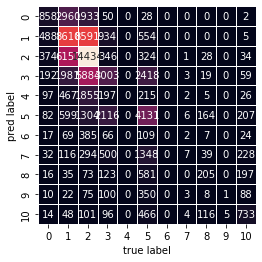

In [55]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(pred, y_compare)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidths=.5
           )
plt.xlabel('true label')
plt.ylabel('pred label')

In [56]:
s = np.sum(mat)

In [61]:
pred[pred==0] = 1
pred[pred==7] = 5

In [62]:
cat_number = len(np.unique(y_compare))
score = 1-np.sum(np.abs(y_compare -pred))/((cat_number-1)*len(y_compare))

In [63]:
print(score)

0.8926601996201353


In [65]:
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.40294968705783374


In [64]:
np.unique(pred)

array([ 1,  2,  3,  5,  8,  9, 10])

Text(91.68, 0.5, 'pred label')

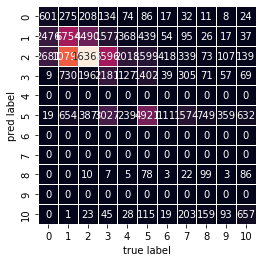

In [74]:
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, linewidths=.7
           )
plt.xlabel('true label')
plt.ylabel('pred label')

In [57]:
l = []
for i in range(len(np.unique(health_care['Stay_cat']))):
    k = len(health_care[health_care['Stay_cat']==i])
    l.append(k/n)


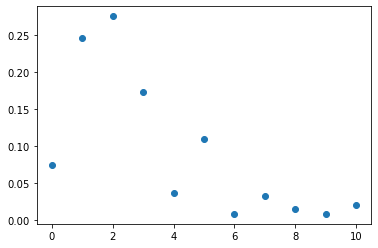

In [58]:
plt.scatter(np.arange(11),l)

In [49]:
len(health_care[health_care['Stay_cat']==1])

77095

In [59]:
mat

array([[  601,   275,   208,   134,    74,    86,    17,    32,    11,
            8,    24],
       [ 2476,  6754,  4490,  1577,   368,   439,    54,    95,    26,
           17,    37],
       [ 2681, 10799, 16363,  6596,  2018,  1599,   418,   339,    73,
          107,   139],
       [    9,   730,   196,  2181,   127,  1402,    39,   305,    71,
           57,    69],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [   19,   654,   387,  3027,   239,  4921,   111,  1574,   749,
          359,   632],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    0,     0,    10,     7,     5,    78,     3,    22,    99,
            3,    86],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    0,     1,    23,    45,    28,   115,    19,   2

In [75]:
Xe.head()

,Hospital_code,Available Extra Rooms in Hospital,patientid,City_Code_Patient,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Hospital_type_code-a,Hospital_type_code-b,...,Ward_Type-U,Ward_Facility_Code-A,Ward_Facility_Code-B,Ward_Facility_Code-C,Ward_Facility_Code-D,Ward_Facility_Code-E,Ward_Facility_Code-F,Type of Admission-Emergency,Type of Admission-Trauma,Type of Admission-Urgent
0,8,3,31397,7.0,2,2,5,4911.0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,2,2,31397,7.0,2,2,5,5954.0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,10,2,31397,7.0,2,2,5,4745.0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,26,2,31397,7.0,2,2,5,7272.0,0,1,...,0,0,0,0,1,0,0,0,1,0
4,26,2,31397,7.0,2,2,5,5558.0,0,1,...,0,0,0,0,1,0,0,0,1,0


# XGBOOST